In [1]:
# Clear GPU Memory

from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
import math
import pandas as pd
import numpy as np
from time import time
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data pre-processing.

In [5]:
data = 'Digital_Music'

In [6]:
train = pd.read_csv('data/'+ data +'_train.csv')
valid = pd.read_csv('data/'+ data +'_valid.csv')
test = pd.read_csv('data/'+ data +'_test.csv')

# train = pd.read_csv('data/Digital_Music_train.csv')
# valid = pd.read_csv('data/Digital_Music_valid.csv')
# test = pd.read_csv('data/Digital_Music_test.csv')

In [7]:
df = pd.concat([train, valid, test])
n_users = df['userID'].nunique()
n_items = df['itemID'].nunique()


In [8]:
train['ratings'].values.astype(np.float32)
valid['ratings'].values.astype(np.float32)
test['ratings'].values.astype(np.float32)

array([5., 4., 5., ..., 5., 5., 5.], dtype=float32)

In [9]:
def add_user_item_reviews(x):
    ur = user_reviews.loc[x["userID"]].values.tolist()
    mr = item_reviews.loc[x["itemID"]].values.tolist()
    x["userReviews"] = " ".join(list(map(lambda x: str(x[0]), ur)))
    x["itemReviews"] = " ".join(list(map(lambda x: str(x[0]), mr)))
    return x

train2 = train.drop("reviewText", axis=1)
user_reviews = pd.pivot_table(train, index=["userID", "itemID"], aggfunc=lambda x: x).drop("ratings", axis=1)  
item_reviews = pd.pivot_table(train, index=["itemID", "userID"], aggfunc=lambda x: x).drop("ratings", axis=1)
train2 = train2.apply(add_user_item_reviews, axis=1)



In [10]:
valid2 = valid.copy()
valid2 = train2[['userID', 'userReviews']].drop_duplicates().merge(valid2, how='right', on='userID')
valid2 = train2[['itemID', 'itemReviews']].drop_duplicates().merge(valid2, how='right', on='itemID')
valid2 = valid2[train2.columns]
valid2 = valid2.dropna()

test2 = test.copy()
test2 = train2[['userID', 'userReviews']].drop_duplicates().merge(test2, how='right', on='userID')
test2 = train2[['itemID', 'itemReviews']].drop_duplicates().merge(test2, how='right', on='itemID')
test2 = test2[train2.columns]
test2 = test2.dropna()

Embed the reviews into GloVe word2vect model. 

The pre-trained GloVe model is downloadable at
https://nlp.stanford.edu/projects/glove/

In [11]:
del train
del valid
del test

In [12]:
import os.path
# functions to embed user reviews into the GloVe word2vect model
def init_embeddings_map(fname):
    with open(os.path.join("glove.6B", fname), encoding="utf8") as glove:
        return {l[0]: np.asarray(l[1:], dtype="float32") for l in
                [line.split() for line in glove]}

def get_embed_func(i_len, u_len, pad_value, embedding_map):
    def embed(row):
        sentence = row["userReviews"].split()[:u_len]
        reviews = list(map(lambda word: embedding_map.get(word)
            if word in embedding_map else pad_value, sentence))
        row["userReviews"] = reviews +[pad_value] * (u_len - len(reviews))
        sentence = row["itemReviews"].split()[:i_len]
        reviews = list(map(lambda word: embedding_map.get(word) if word in embedding_map else pad_value, sentence))
        row["itemReviews"] = reviews +[pad_value] * (i_len - len(reviews))
        return row
    return embed

emb_size = 50 #or 100, 200, 300
embedding_map = init_embeddings_map("glove.6B." + str(emb_size) + "d.txt")

user_sizes = train2.loc[:, "userReviews"].apply(lambda x: x.split()).apply(len) 
u_ptile = 50
u_len = int(np.percentile(user_sizes, u_ptile))
del user_sizes

item_sizes = train2.loc[:, "itemReviews"].apply(lambda x: x.split()).apply(len)
i_ptile = 50
i_len = int(np.percentile(item_sizes, i_ptile))
del item_sizes

embedding_fn = get_embed_func(i_len, u_len, np.array([0.0] * emb_size), embedding_map)
    
train_embedded = train2.apply(embedding_fn, axis=1)
valid_embedded = valid2.apply(embedding_fn, axis=1)
test_embedded = test2.apply(embedding_fn, axis=1)

# print(u_len, i_len) # size of input in deep neural networks, useful to set parameters
train_embedded.head()

del embedding_fn

# Deep learning models

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, GRU, LSTM, MaxPooling1D, Flatten, BatchNormalization, Bidirectional
from tensorflow.keras.layers import Input, Dense, Dropout, Add, Dot, Concatenate, Embedding, Reshape, Activation, Lambda
from tensorflow.keras.regularizers import l2

In [14]:
tf.random.set_seed(27)

## Matrix Factorization

In [15]:
# Train test for Matrix Factorization
X_train = train2[['userID', 'itemID']].values
y_train = train2['ratings'].values

X_valid = valid2[['userID', 'itemID']].values
y_valid = valid2['ratings'].values

X_test = test2[['userID', 'itemID']].values
y_test = test2['ratings'].values


X_train_array = [X_train[:, 0], X_train[:, 1]]
X_valid_array = [X_valid[:, 0], X_valid[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

min_rating = min(train2['ratings'])
max_rating = max(train2['ratings'])

del train2
del valid2
del test2

In [16]:
n_factors = 100

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
    
def MatrixFactorization(n_users, n_items, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    item = Input(shape=(1,))
    i = EmbeddingLayer(n_items, n_factors)(item)
    ib = EmbeddingLayer(n_items, 1)(item)
    x = Dot(axes=1)([u, i])
    x = Add()([x, ub, ib])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, item], outputs=x)
    model.compile(loss='mse', optimizer='Adam')
    return model

model_MF = MatrixFactorization(n_users, n_items, n_factors, min_rating, max_rating)

In [17]:
batch_size = 32
epochs = 100

tensorboard = TensorBoard(log_dir='model\\' + data + '\\mf_log')
earlystop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('model/'+ data + '/mf_weight/mf_weights.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss', save_best_only=True)

history_MF = model_MF.fit(x=X_train_array, y=y_train, batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_data=(X_valid_array, y_valid), callbacks=[tensorboard, earlystop, checkpoint])

model_MF.save('model/' + data + '/mf.h5')


Train on 87087 samples, validate on 28473 samples
Epoch 1/100
87087/87087 [==============================] - 32s 363us/sample - loss: 2.9655 - val_loss: 2.4876
Epoch 2/100
87087/87087 [==============================] - 30s 348us/sample - loss: 1.5746 - val_loss: 1.4161
Epoch 3/100
87087/87087 [==============================] - 30s 348us/sample - loss: 0.5302 - val_loss: 0.9465
Epoch 4/100
87087/87087 [==============================] - 30s 349us/sample - loss: 0.2211 - val_loss: 0.7797
Epoch 5/100
87087/87087 [==============================] - 32s 364us/sample - loss: 0.1414 - val_loss: 0.7042
Epoch 6/100
87087/87087 [==============================] - 31s 352us/sample - loss: 0.1238 - val_loss: 0.6561
Epoch 7/100
87087/87087 [==============================] - 31s 355us/sample - loss: 0.1231 - val_loss: 0.6236
Epoch 8/100
87087/87087 [==============================] - 30s 348us/sample - loss: 0.1213 - val_loss: 0.5972
Epoch 9/100
87087/87087 [==============================] - 32s 363us/s

In [18]:
model_MF.evaluate(X_test_array, y_test)

28511/28511 [==============================] - 5s 159us/sample - loss: 0.4640


0.4639778082224668

In [19]:
hist_df = pd.DataFrame(history_MF.history)
hist_csv_file = 'model/'+ data + '/history_MF.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

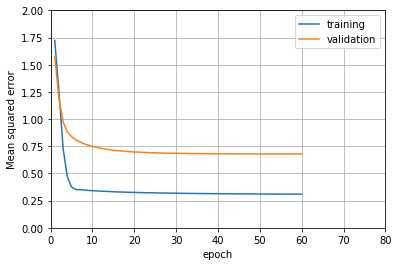

In [20]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history_MF.epoch ],
                     'training': [ math.sqrt(loss) for loss in history_MF.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history_MF.history['val_loss'] ]})
#ax = loss.ix[:,:].plot(x='epoch', figsize={1,30}, grid=True)
ax = loss.loc[:,:].plot(x='epoch', grid=True)
ax.set_ylabel("Mean squared error")
ax.set_xlim([0,80])
ax.set_ylim([-0.0,2.0]);

## DeepCoNN

In [21]:
# Train Test for DeepConn

train_user_reviews = np.array(list(train_embedded.loc[:, "userReviews"]))
train_item_reviews = np.array(list(train_embedded.loc[:, "itemReviews"]))

train_inputs = [train_user_reviews, train_item_reviews]
train_outputs = train_embedded.loc[:, "ratings"]

valid_user_reviews = np.array(list(valid_embedded.loc[:, "userReviews"]))
valid_item_reviews = np.array(list(valid_embedded.loc[:, "itemReviews"]))

valid_inputs = [valid_user_reviews, valid_item_reviews]
valid_outputs = valid_embedded.loc[:, "ratings"]

test_user_reviews = np.array(list(test_embedded.loc[:, "userReviews"]))
test_item_reviews = np.array(list(test_embedded.loc[:, "itemReviews"]))

test_inputs = [test_user_reviews, test_item_reviews]
test_outputs = test_embedded.loc[:, "ratings"]

del train_embedded
del valid_embedded
del test_embedded

### CNN

In [22]:
def cnn_tower(max_len, embedding_size, hidden_size, filters=32, kernel_size=3):
        input_layer = Input(shape=(max_len, embedding_size))
        tower = Conv1D(filters=filters, kernel_size=kernel_size, activation="relu")(input_layer)
        tower = MaxPooling1D()(tower)
#         tower = Conv1D(filters=filters, kernel_size=kernel_size, activation="relu")(tower)
#         tower = MaxPooling1D()(tower)
        tower = Flatten()(tower)
        tower = Dense(hidden_size, activation="relu")(tower)
        tower = Dropout(0.4)(tower)
        return input_layer, tower
    
def DeepCoNN_CNN_model(embedding_size, hidden_size, u_len, i_len):
    inputU, towerU = cnn_tower(u_len, embedding_size, hidden_size)
    inputI, towerI = cnn_tower(i_len, embedding_size, hidden_size)
    joined = Concatenate()([towerU, towerI])
    outNeuron = Dense(1)(joined)
    dotproduct = Dot(axes=1)([towerU, towerI])
    output_layer = Add()([outNeuron, dotproduct])
        
    model = Model(inputs=[inputU, inputI], outputs=[output_layer])
    return model

hidden_size = 64

model_cnn = DeepCoNN_CNN_model(emb_size, hidden_size, u_len, i_len)
model_cnn.compile(optimizer='Adam', loss='mse')
model_cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 46, 50)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 109, 50)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 44, 32)       4832        input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 107, 32)      4832        input_4[0][0]                    
____________________________________________________________________________________________

In [23]:
batch_size = 32
epochs = 50

tensorboard = TensorBoard(log_dir='model\\' + data + '\\cnn_log')
earlystop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('model/' + data + '/cnn_weight/cnn_weights.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss', save_best_only=True)
history_cnn = model_cnn.fit(train_inputs, train_outputs, callbacks=[tensorboard, earlystop, checkpoint], 
                              validation_data=(valid_inputs, valid_outputs), batch_size=batch_size, epochs=epochs)

model_cnn.save('model/' + data + '/cnn.h5')

Train on 87087 samples, validate on 28473 samples
Epoch 1/50
87087/87087 [==============================] - 12s 138us/sample - loss: 0.9747 - val_loss: 0.4698
Epoch 2/50
87087/87087 [==============================] - 10s 119us/sample - loss: 0.6409 - val_loss: 0.4240
Epoch 3/50
87087/87087 [==============================] - 11s 125us/sample - loss: 0.5391 - val_loss: 0.4145
Epoch 4/50
87087/87087 [==============================] - 10s 120us/sample - loss: 0.4773 - val_loss: 0.4085
Epoch 5/50
87087/87087 [==============================] - 10s 117us/sample - loss: 0.4402 - val_loss: 0.4070
Epoch 6/50
87087/87087 [==============================] - 10s 118us/sample - loss: 0.4166 - val_loss: 0.3935
Epoch 7/50
87087/87087 [==============================] - 10s 118us/sample - loss: 0.3978 - val_loss: 0.3942
Epoch 8/50
87087/87087 [==============================] - 10s 119us/sample - loss: 0.3910 - val_loss: 0.3890
Epoch 9/50
87087/87087 [==============================] - 10s 117us/sample - l

In [24]:
hist_df = pd.DataFrame(history_cnn.history)
hist_csv_file = 'model/'+ data + '/history_cnn.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [25]:
model_cnn.evaluate(test_inputs, test_outputs)

28511/28511 [==============================] - 2s 57us/sample - loss: 0.3940


0.39401102739521726

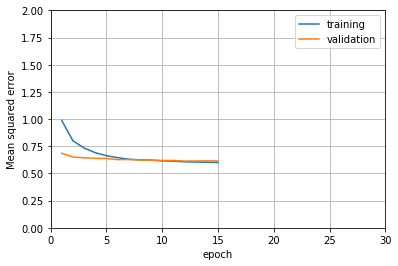

In [26]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history_cnn.epoch ],
                     'training': [ math.sqrt(loss) for loss in history_cnn.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history_cnn.history['val_loss'] ]})
ax = loss.loc[:,:].plot(x='epoch', grid=True)
ax.set_ylabel("Mean squared error")
ax.set_xlim([0,30])
ax.set_ylim([-0.0,2.0]);

### GRU

In [27]:
def gru_tower(max_len, embedding_size, hidden_size, rnn_hidden_size):
        input_layer = Input(shape=(max_len, embedding_size))
        tower = GRU(rnn_hidden_size, activation="tanh")(input_layer)
        tower = Dense(hidden_size, activation="relu")(tower)
        tower = Dropout(0.4)(tower)
        return input_layer, tower
    
def DeepCoNN_GRU_model(embedding_size, hidden_size, rnn_hidden_size, u_len, i_len):
    inputU, towerU = gru_tower(u_len, embedding_size, hidden_size, rnn_hidden_size)
    InputI, towerI = gru_tower(i_len, embedding_size, hidden_size, rnn_hidden_size)
    joined = Concatenate()([towerU, towerI])
    outNeuron = Dense(1)(joined)
    dotproduct = Dot(axes=1)([towerU, towerI])
    output_layer = Add()([outNeuron, dotproduct])
        
    model = Model(inputs=[inputU, InputI], outputs=[output_layer])
    return model

hidden_size = 64
rnn_hidden_size = 64

model_gru = DeepCoNN_GRU_model(emb_size, hidden_size, rnn_hidden_size, u_len, i_len)
model_gru.compile(optimizer='Adam', loss='mse')
model_gru.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 46, 50)]     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 109, 50)]    0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 64)           22272       input_5[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 64)           22272       input_6[0][0]                    
____________________________________________________________________________________________

In [28]:
batch_size = 32
epochs = 50

tensorboard = TensorBoard(log_dir='model\\' + data + '\\gru_log')
earlystop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('model/' + data + '/gru_weight/gru_weights.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss', save_best_only=True)
history_gru = model_gru.fit(train_inputs, train_outputs, callbacks=[tensorboard, earlystop, checkpoint], 
                              validation_data=(valid_inputs, valid_outputs), batch_size=batch_size, epochs=epochs)

model_gru.save('model/' + data + '/gru.h5')

Train on 87087 samples, validate on 28473 samples
Epoch 1/50
87087/87087 [==============================] - 24s 275us/sample - loss: 0.9396 - val_loss: 0.4456
Epoch 2/50
87087/87087 [==============================] - 22s 257us/sample - loss: 0.6576 - val_loss: 0.4384
Epoch 3/50
87087/87087 [==============================] - 23s 261us/sample - loss: 0.5623 - val_loss: 0.4280
Epoch 4/50
87087/87087 [==============================] - 22s 255us/sample - loss: 0.4943 - val_loss: 0.3933
Epoch 5/50
87087/87087 [==============================] - 22s 255us/sample - loss: 0.4429 - val_loss: 0.4158
Epoch 6/50
87087/87087 [==============================] - 22s 254us/sample - loss: 0.4118 - val_loss: 0.3783
Epoch 7/50
87087/87087 [==============================] - 22s 256us/sample - loss: 0.3854 - val_loss: 0.3760
Epoch 8/50
87087/87087 [==============================] - 22s 257us/sample - loss: 0.3668 - val_loss: 0.3743
Epoch 9/50
87087/87087 [==============================] - 22s 254us/sample - l

In [29]:
hist_df = pd.DataFrame(history_gru.history)
hist_csv_file = 'model/'+ data + '/history_gru.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [30]:
model_gru.evaluate(test_inputs, test_outputs)

28511/28511 [==============================] - 3s 109us/sample - loss: 0.3723


0.37232296783592705

### Stacked GRU

In [31]:
# def gru_tower(max_len, embedding_size, hidden_size, rnn_hidden_size):
#         input_layer = Input(shape=(max_len, embedding_size))
#         tower = GRU(rnn_hidden_size, activation="tanh", dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(input_layer)
#         tower = BatchNormalization()(tower)
#         tower = GRU(16, activation='tanh', dropout=0.2, recurrent_dropout=0.2)(tower)
#         tower = Dense(hidden_size, activation="relu")(tower)
#         return input_layer, tower
    
# def DeepCoNN_Stacked_GRU_model(embedding_size, hidden_size, rnn_hidden_size, u_len, i_len):
#     inputU, towerU = gru_tower(u_len, embedding_size, hidden_size, rnn_hidden_size)
#     InputI, towerI = gru_tower(i_len, embedding_size, hidden_size, rnn_hidden_size)
#     joined = Concatenate()([towerU, towerI])
#     outNeuron = Dense(1)(joined)
#     dotproduct = Dot(axes=1)([towerU, towerI])
#     output_layer = Add()([outNeuron, dotproduct])
        
#     model = Model(inputs=[inputU, InputI], outputs=[output_layer])
#     return model

# hidden_size = 64
# rnn_hidden_size = 64

# model_stacked_gru = DeepCoNN_Stacked_GRU_model(emb_size, hidden_size, rnn_hidden_size, u_len, i_len)
# model_stacked_gru.compile(optimizer='Adam', loss='mse')
# model_stacked_gru.summary()

In [32]:
# batch_size = 32
# epochs = 50

# tensorboard = TensorBoard(log_dir='model\\' + data + '\\stacked_gru_log')
# earlystop = EarlyStopping(monitor='val_loss', patience=3)
# checkpoint = ModelCheckpoint('model/' + data + '/stacked_gru_weight/stacked_gru_weights.{epoch:02d}-{val_loss:.2f}.h5',
#                              monitor='val_loss', save_best_only=True)
# history_stacked_gru = model_stacked_gru.fit(train_inputs, train_outputs, callbacks=[tensorboard, earlystop, checkpoint], 
#                               validation_data=(valid_inputs, valid_outputs), batch_size=batch_size, epochs=epochs)

# model_stacked_gru.save('model/' + data + '/stacked_gru.h5')

In [33]:
# model_stacked_gru.evaluate(test_inputs, test_outputs)

### Bidirection GRU


In [34]:
def gru_tower(max_len, embedding_size, hidden_size, rnn_hidden_size):
        input_layer = Input(shape=(max_len, embedding_size))
        tower = Bidirectional(GRU(rnn_hidden_size, activation="tanh", dropout=0.1, recurrent_dropout=0.1))(input_layer)
        tower = Dense(hidden_size, activation="relu")(tower)
        tower = Dropout(0.4)(tower)
        return input_layer, tower
    
def DeepCoNN_Bi_GRU_model(embedding_size, hidden_size, rnn_hidden_size, u_len, i_len):
    inputU, towerU = gru_tower(u_len, embedding_size, hidden_size, rnn_hidden_size)
    InputI, towerI = gru_tower(i_len, embedding_size, hidden_size, rnn_hidden_size)
    joined = Concatenate()([towerU, towerI])
    outNeuron = Dense(1)(joined)
    dotproduct = Dot(axes=1)([towerU, towerI])
    output_layer = Add()([outNeuron, dotproduct])
        
    model = Model(inputs=[inputU, InputI], outputs=[output_layer])
    return model

hidden_size = 64
rnn_hidden_size = 64

model_bi_gru = DeepCoNN_Bi_GRU_model(emb_size, hidden_size, rnn_hidden_size, u_len, i_len)
model_bi_gru.compile(optimizer='Adam', loss='mse')
model_bi_gru.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 46, 50)]     0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 109, 50)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128)          44544       input_7[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128)          44544       input_8[0][0]                    
____________________________________________________________________________________________

In [35]:
batch_size = 32
epochs = 50

tensorboard = TensorBoard(log_dir='model\\' + data + '\\bidirectional_gru_log')
earlystop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('model/' + data + '/bidirectional_gru_weight/bidirectional_gru_weights.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss', save_best_only=True)
history_bi_gru = model_bi_gru.fit(train_inputs, train_outputs, callbacks=[tensorboard, earlystop, checkpoint], 
                              validation_data=(valid_inputs, valid_outputs), batch_size=batch_size, epochs=epochs)

model_bi_gru.save('model/' + data + '/bidirectional_gru.h5')

Train on 87087 samples, validate on 28473 samples
Epoch 1/50
87087/87087 [==============================] - 905s 10ms/sample - loss: 0.8312 - val_loss: 0.4500
Epoch 2/50
87087/87087 [==============================] - 906s 10ms/sample - loss: 0.6361 - val_loss: 0.4469
Epoch 3/50
87087/87087 [==============================] - 901s 10ms/sample - loss: 0.5532 - val_loss: 0.4385
Epoch 4/50
87087/87087 [==============================] - 910s 10ms/sample - loss: 0.4881 - val_loss: 0.3904
Epoch 5/50
87087/87087 [==============================] - 912s 10ms/sample - loss: 0.4450 - val_loss: 0.4041
Epoch 6/50
87087/87087 [==============================] - 918s 11ms/sample - loss: 0.4156 - val_loss: 0.3838
Epoch 7/50
87087/87087 [==============================] - 912s 10ms/sample - loss: 0.3941 - val_loss: 0.3738
Epoch 8/50
87087/87087 [==============================] - 915s 11ms/sample - loss: 0.3783 - val_loss: 0.3723
Epoch 9/50
87087/87087 [==============================] - 912s 10ms/sample - l

In [36]:
hist_df = pd.DataFrame(history_bi_gru.history)
hist_csv_file = 'model/'+ data + '/history_bi_gru.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [37]:
model_bi_gru.evaluate(test_inputs, test_outputs)

28511/28511 [==============================] - 51s 2ms/sample - loss: 0.3649


0.36488996510888505

### LSTM

In [38]:
# LSTM model
def lstm_tower(max_len, embedding_size, hidden_size, rnn_hidden_size):
        input_layer = Input(shape=(max_len, embedding_size))
        tower = LSTM(rnn_hidden_size, activation="tanh")(input_layer)
        tower = Dense(hidden_size, activation="relu")(tower)
        tower = Dropout(0.4)(tower)
        return input_layer, tower
    
def DeepCoNN_LSTM_model(embedding_size, hidden_size, rnn_hidden_size, u_len, i_len):
    inputU, towerU = lstm_tower(u_len, embedding_size, hidden_size, rnn_hidden_size)
    InputI, towerI = lstm_tower(i_len, embedding_size, hidden_size, rnn_hidden_size)
    joined = Concatenate()([towerU, towerI])
    outNeuron = Dense(1)(joined)
    dotproduct = Dot(axes=1)([towerU, towerI])
    output_layer = Add()([outNeuron, dotproduct])
        
    model = Model(inputs=[inputU, InputI], outputs=[output_layer])
    return model


hidden_size = 64
rnn_hidden_size = 64

model_lstm = DeepCoNN_LSTM_model(emb_size, hidden_size, rnn_hidden_size, u_len, i_len)
model_lstm.compile(optimizer='Adam', loss='mse')
model_lstm.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 46, 50)]     0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 109, 50)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 64)           29440       input_9[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 64)           29440       input_10[0][0]                   
____________________________________________________________________________________________

In [39]:
batch_size = 32
epochs = 50

tensorboard = TensorBoard(log_dir='model\\' + data + '\\lstm_log')
earlystop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('model/' + data + '/lstm_weight/lstm_weights.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss', save_best_only=True)
history_lstm = model_lstm.fit(train_inputs, train_outputs, callbacks=[tensorboard, earlystop, checkpoint], 
                              validation_data=(valid_inputs, valid_outputs), batch_size=batch_size, epochs=epochs)

model_lstm.save('model/' + data + '/lstm.h5')

Train on 87087 samples, validate on 28473 samples
Epoch 1/50
87087/87087 [==============================] - 25s 290us/sample - loss: 0.9272 - val_loss: 0.4568
Epoch 2/50
87087/87087 [==============================] - 24s 270us/sample - loss: 0.6864 - val_loss: 0.4315
Epoch 3/50
87087/87087 [==============================] - 24s 270us/sample - loss: 0.5733 - val_loss: 0.4349
Epoch 4/50
87087/87087 [==============================] - 23s 269us/sample - loss: 0.5017 - val_loss: 0.4087
Epoch 5/50
87087/87087 [==============================] - 24s 271us/sample - loss: 0.4504 - val_loss: 0.4168
Epoch 6/50
87087/87087 [==============================] - 24s 271us/sample - loss: 0.4188 - val_loss: 0.3854
Epoch 7/50
87087/87087 [==============================] - 23s 268us/sample - loss: 0.3913 - val_loss: 0.3822
Epoch 8/50
87087/87087 [==============================] - 24s 271us/sample - loss: 0.3774 - val_loss: 0.3820
Epoch 9/50
87087/87087 [==============================] - 24s 274us/sample - l

Prediction and errors

In [40]:
hist_df = pd.DataFrame(history_lstm.history)
hist_csv_file = 'model/'+ data + '/history_lstm.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [41]:
model_lstm.evaluate(test_inputs, test_outputs)

28511/28511 [==============================] - 3s 115us/sample - loss: 0.3804


0.3804241715366957

### Stacked LSTM

In [42]:
# def lstm_tower(max_len, embedding_size, hidden_size, rnn_hidden_size):
#         input_layer = Input(shape=(max_len, embedding_size))
#         tower = GRU(rnn_hidden_size, activation="tanh", dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(input_layer)
#         tower = BatchNormalization()(tower)
#         tower = GRU(16, activation='tanh', dropout=0.2, recurrent_dropout=0.2)(tower)
#         tower = Dense(hidden_size, activation="relu")(tower)
#         return input_layer, tower
    
# def DeepCoNN_Stacked_LSTM_model(embedding_size, hidden_size, rnn_hidden_size, u_len, i_len):
#     inputU, towerU = lstm_tower(u_len, embedding_size, hidden_size, rnn_hidden_size)
#     InputI, towerI = lstm_tower(i_len, embedding_size, hidden_size, rnn_hidden_size)
#     joined = Concatenate()([towerU, towerI])
#     outNeuron = Dense(1)(joined)
#     dotproduct = Dot(axes=1)([towerU, towerI])
#     output_layer = Add()([outNeuron, dotproduct])
        
#     model = Model(inputs=[inputU, InputI], outputs=[output_layer])
#     return model

# hidden_size = 64
# rnn_hidden_size = 64

# model_stacked_lstm = DeepCoNN_Stacked_LSTM_model(emb_size, hidden_size, rnn_hidden_size, u_len, i_len)
# model_stacked_lstm.compile(optimizer='Adam', loss='mse')
# model_stacked_lstm.summary()

In [43]:
# batch_size = 32
# epochs = 50

# tensorboard = TensorBoard(log_dir='model\\' + data + '\\stacked_lstm_log')
# earlystop = EarlyStopping(monitor='val_loss', patience=3)
# checkpoint = ModelCheckpoint('model/' + data + '/stacked_lstm_weight/stacked_lstm_weights.{epoch:02d}-{val_loss:.2f}.h5',
#                              monitor='val_loss', save_best_only=True)
# history_stacked_lstm = model_stacked_lstm.fit(train_inputs, train_outputs, callbacks=[tensorboard, earlystop, checkpoint], 
#                               validation_data=(valid_inputs, valid_outputs), batch_size=batch_size, epochs=epochs)

# model_stacked_lstm.save('model/' + data + '/stacked_lstm.h5')

In [44]:
# model_stacked_lstm.evaluate(test_inputs, test_outputs)

### Bidirection LSTM

In [45]:
def lstm_tower(max_len, embedding_size, hidden_size, rnn_hidden_size):
        input_layer = Input(shape=(max_len, embedding_size))
        tower = Bidirectional(LSTM(rnn_hidden_size, activation="tanh", dropout=0.1, recurrent_dropout=0.1))(input_layer)
        tower = Dense(hidden_size, activation="relu")(tower)
        tower = Dropout(0.4)(tower)
        return input_layer, tower
    
def DeepCoNN_Bi_LSTM_model(embedding_size, hidden_size, rnn_hidden_size, u_len, i_len):
    inputU, towerU = lstm_tower(u_len, embedding_size, hidden_size, rnn_hidden_size)
    InputI, towerI = lstm_tower(i_len, embedding_size, hidden_size, rnn_hidden_size)
    joined = Concatenate()([towerU, towerI])
    outNeuron = Dense(1)(joined)
    dotproduct = Dot(axes=1)([towerU, towerI])
    output_layer = Add()([outNeuron, dotproduct])
        
    model = Model(inputs=[inputU, InputI], outputs=[output_layer])
    return model

hidden_size = 64
rnn_hidden_size = 64

model_bi_lstm = DeepCoNN_Bi_LSTM_model(emb_size, hidden_size, rnn_hidden_size, u_len, i_len)
model_bi_lstm.compile(optimizer='Adam', loss='mse')
model_bi_lstm.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 46, 50)]     0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 109, 50)]    0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 128)          58880       input_11[0][0]                   
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 128)          58880       input_12[0][0]                   
____________________________________________________________________________________________

In [46]:
batch_size = 32
epochs = 50

tensorboard = TensorBoard(log_dir='model\\' + data + '\\bidirectional_lstm_log')
earlystop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('model/' + data + '/bidirectional_lstm_weight/bidirectional_lstm_weights.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss', save_best_only=True)
history_bi_lstm = model_bi_lstm.fit(train_inputs, train_outputs, callbacks=[tensorboard, earlystop, checkpoint], 
                              validation_data=(valid_inputs, valid_outputs), batch_size=batch_size, epochs=epochs)

model_bi_lstm.save('model/' + data + '/bidirectional_lstm.h5')

Train on 87087 samples, validate on 28473 samples
Epoch 1/50
87087/87087 [==============================] - 956s 11ms/sample - loss: 0.8234 - val_loss: 0.4559
Epoch 2/50
87087/87087 [==============================] - 952s 11ms/sample - loss: 0.6413 - val_loss: 0.4290
Epoch 3/50
87087/87087 [==============================] - 959s 11ms/sample - loss: 0.5574 - val_loss: 0.4304
Epoch 4/50
87087/87087 [==============================] - 1038s 12ms/sample - loss: 0.4893 - val_loss: 0.3943
Epoch 5/50
87087/87087 [==============================] - 951s 11ms/sample - loss: 0.4489 - val_loss: 0.4000
Epoch 6/50
87087/87087 [==============================] - 944s 11ms/sample - loss: 0.4133 - val_loss: 0.3766
Epoch 7/50
87087/87087 [==============================] - 1076s 12ms/sample - loss: 0.3921 - val_loss: 0.3732
Epoch 8/50
87087/87087 [==============================] - 962s 11ms/sample - loss: 0.3738 - val_loss: 0.3750
Epoch 9/50
87087/87087 [==============================] - 951s 11ms/sample -

In [47]:
hist_df = pd.DataFrame(history_bi_lstm.history)
hist_csv_file = 'model/'+ data + '/history_bi_lstm.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [48]:
model_bi_lstm.evaluate(test_inputs, test_outputs)

28511/28511 [==============================] - 53s 2ms/sample - loss: 0.3696


0.36957216835010265

# Evaluate

In [49]:
predictions_mf = model_MF.predict(X_test_array)
predictions_cnn = model_cnn.predict(test_inputs)
predictions_gru = model_gru.predict(test_inputs)
# predictions_stacked_gru = model_stacked_gru.predict(test_inputs)
predictions_bi_gru = model_bi_gru.predict(test_inputs)
predictions_lstm = model_lstm.predict(test_inputs)
# predictions_stacked_lstm = model_stacked_lstm.predict(test_inputs)
predictions_bi_lstm = model_bi_lstm.predict(test_inputs)

error_mf = np.square(predictions_mf.reshape(-1,) - y_test)
print("Test MSE for MF model :", np.average(error_mf))

error_cnn = np.square(predictions_cnn.reshape(-1,) - test_outputs)
print("Test MSE for CNN model :", np.average(error_cnn))

error_gru = np.square(predictions_gru.reshape(-1,) - test_outputs)
print("Test MSE for GRU model :", np.average(error_gru))

# error_stacked_gru = np.square(predictions_stacked_gru.reshape(-1,) - test_outputs)
# print("Test MSE for Stacked GRU model :", np.average(error_stacked_gru))

error_bi_gru = np.square(predictions_bi_gru.reshape(-1,) - test_outputs)
print("Test MSE for Bidirectional GRU model :", np.average(error_bi_gru))

error_lstm = np.square(predictions_lstm.reshape(-1,) - test_outputs)
print("Test MSE for LSTM model :", np.average(error_lstm))

# error_stacked_lstm = np.square(predictions_stacked_lstm.reshape(-1,) - test_outputs)
# print("Test MSE for Stacked LSTM model :", np.average(error_stacked_lstm))

error_bi_lstm = np.square(predictions_bi_lstm.reshape(-1,) - test_outputs)
print("Test MSE for Bidirectional LSTM model :", np.average(error_bi_lstm))



Test MSE for MF model : 0.40052583161058947
Test MSE for CNN model : 0.39401102
Test MSE for GRU model : 0.37232298
Test MSE for Bidirectional GRU model : 0.36488995
Test MSE for LSTM model : 0.38042417
Test MSE for Bidirectional LSTM model : 0.36957213


# Hybrid MF - DeepCoNN

In [50]:
weight = np.linspace(0, 1, num=11)

def Weight_MF_DeepCoNN(weight, mf, deepconn, text):
    print(text)
    for i in weight:
        error = np.square(((mf.reshape(-1,)*i)+(deepconn.reshape(-1,)*(1-i))) - test_outputs)
        print(round(i,1), np.average(error))
    print('-------------------------------------------------')       
    

In [51]:
Weight_MF_DeepCoNN(weight, predictions_mf, predictions_cnn, 'CNN')
Weight_MF_DeepCoNN(weight, predictions_mf, predictions_gru, 'GRU')
# Weight_MF_DeepCoNN(weight, predictions_mf, predictions_stacked_gru, 'Stacked GRU')
Weight_MF_DeepCoNN(weight, predictions_mf, predictions_bi_gru, 'Bidirectional GRU')
Weight_MF_DeepCoNN(weight, predictions_mf, predictions_lstm, 'LSTM')
# Weight_MF_DeepCoNN(weight, predictions_mf, predictions_stacked_lstm, 'Stacked LSTM')
Weight_MF_DeepCoNN(weight, predictions_mf, predictions_bi_lstm, 'Bidirectional LSTM')

CNN
0.0 0.39401102
0.1 0.3829948
0.2 0.3745713
0.3 0.3687407
0.4 0.36550292
0.5 0.364858
0.6 0.36680585
0.7 0.37134662
0.8 0.3784802
0.9 0.38820666
1.0 0.40052584
-------------------------------------------------
GRU
0.0 0.37232298
0.1 0.3619158
0.2 0.354448
0.3 0.3499197
0.4 0.34833083
0.5 0.3496814
0.6 0.3539714
0.7 0.36120084
0.8 0.37136972
0.9 0.3844781
1.0 0.40052584
-------------------------------------------------
Bidirectional GRU
0.0 0.36488995
0.1 0.35613143
0.2 0.35011116
0.3 0.3468292
0.4 0.34628537
0.5 0.34847984
0.6 0.35341257
0.7 0.3610835
0.8 0.3714927
0.9 0.38464016
1.0 0.40052584
-------------------------------------------------
LSTM
0.0 0.38042417
0.1 0.37102753
0.2 0.36416572
0.3 0.3598388
0.4 0.35804662
0.5 0.3587894
0.6 0.36206698
0.7 0.36787942
0.8 0.37622666
0.9 0.3871089
1.0 0.40052584
-------------------------------------------------
Bidirectional LSTM
0.0 0.36957213
0.1 0.36071432
0.2 0.35451278
0.3 0.35096747
0.4 0.35007843
0.5 0.3518457
0.6 0.35626915
0.7 0